In [1]:
import pandas as pd
import numpy as np
from math import sqrt

from io import BytesIO
from io import StringIO
import boto3

import matplotlib.pyplot as plt
import seaborn as sns
import time
import datetime
random_state = 5

from sklearn.linear_model import LinearRegression, Lasso
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, confusion_matrix
import shap

from statsmodels.stats.outliers_influence import variance_inflation_factor

#adjust view
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 10)
pd.set_option('display.width', 1000)

In [7]:
pd.set_option('display.max_columns', None)

df = pd.read_csv('data/cleaned_games.csv')
df['target_class']  = np.where(df['target'] == 1, "away", "home")
df = df.drop(columns = ['Unnamed: 0', 'target'])
df.head()

,first_downs_away,first_downs_home,passing_yards_away,passing_yards_home,rushing_yards_away,rushing_yards_home,total_yards_away,total_yards_home,rushing_attempts_away,rushing_attempts_home,fumbles_away,fumbles_home,int_away,int_home,turnovers_away,turnovers_home,drives_away,drives_home,def_st_td_away,def_st_td_home,possession_away,possession_home,score_away,score_home,third_down_conversion,third_downs_home_conversion,fourth_downs_away_conversion,fourth_downs_home_conversion,comp_att_away_conversion,comp_att_home_conversion,sacks_away_occur,sacks_away_yards,sacks_home_occur,sacks_home_yards,penalties_away_occur,penalties_away_yards,penalties_home_occur,penalties_home_yards,target_class
0,13,21,166,318,113,43,279,361,25,22,0,0,1,3,1,3,13,15,0,0,27.32,32.28,16,13,0.333333,0.562500,0.0,0.0,0.615385,0.622222,0,0,3,24,5,29,10,80,away
1,18,26,193,242,73,142,266,384,14,32,1,1,0,2,1,3,17,18,2,0,21.06,39.08,37,31,0.250000,0.411765,0.0,1.0,0.800000,0.666667,3,17,4,29,10,90,10,82,away
2,19,20,228,288,140,80,368,368,33,26,1,1,2,1,3,2,17,17,0,0,31.31,28.29,23,27,0.384615,0.538462,0.0,0.0,0.571429,0.606061,1,6,1,9,8,52,4,33,home
3,27,13,160,167,241,36,401,203,45,13,0,0,0,1,0,1,11,15,0,0,37.48,22.12,34,6,0.600000,0.363636,0.0,0.0,0.789474,0.580645,1,0,4,31,4,39,9,57,away
4,24,24,276,352,194,59,470,411,30,20,0,1,1,0,1,1,20,17,0,0,30.16,29.44,40,39,0.454545,0.363636,0.0,0.0,0.689655,0.700000,0,0,1,7,9,87,4,38,away


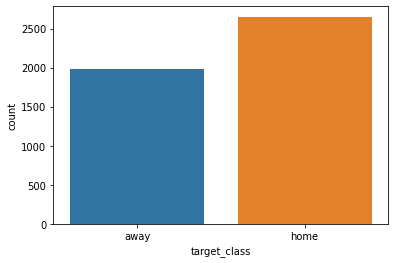

In [9]:
sns.countplot(x='target_class', data=df)
plt.show()

In [10]:
df.groupby('target_class').mean()

,first_downs_away,first_downs_home,passing_yards_away,passing_yards_home,rushing_yards_away,rushing_yards_home,total_yards_away,total_yards_home,rushing_attempts_away,rushing_attempts_home,fumbles_away,fumbles_home,int_away,int_home,turnovers_away,turnovers_home,drives_away,drives_home,def_st_td_away,def_st_td_home,possession_away,possession_home,score_away,score_home,third_down_conversion,third_downs_home_conversion,fourth_downs_away_conversion,fourth_downs_home_conversion,comp_att_away_conversion,comp_att_home_conversion,sacks_away_occur,sacks_away_yards,sacks_home_occur,sacks_home_yards,penalties_away_occur,penalties_away_yards,penalties_home_occur,penalties_home_yards
target_class,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
away,20.350531,18.376834,227.769853,220.389479,132.164896,96.015175,359.934750,316.404654,31.713202,22.870511,0.448660,0.839656,0.563986,1.361153,1.012645,2.200809,12.388467,12.479514,0.569044,0.181588,31.892701,28.165771,27.499747,16.711684,0.420428,0.344611,0.277390,0.293298,0.639554,0.582881,1.758220,10.835104,2.805260,18.385938,6.373799,53.527061,6.495195,54.157815
home,17.621652,20.823840,214.110902,231.185590,93.009430,134.066390,307.120332,365.251980,22.788382,31.525462,0.816296,0.512260,1.295737,0.584685,2.112033,1.096945,12.553376,12.342889,0.181064,0.510751,28.161916,31.880392,15.852131,28.205206,0.337439,0.423287,0.300224,0.278448,0.582136,0.645082,2.789513,18.550358,1.751415,11.101471,6.747642,55.915126,5.993965,50.121086


In [8]:
df.corr()

,first_downs_away,first_downs_home,passing_yards_away,passing_yards_home,rushing_yards_away,rushing_yards_home,total_yards_away,total_yards_home,rushing_attempts_away,rushing_attempts_home,fumbles_away,fumbles_home,int_away,int_home,turnovers_away,turnovers_home,drives_away,drives_home,def_st_td_away,def_st_td_home,possession_away,possession_home,score_away,score_home,third_down_conversion,third_downs_home_conversion,fourth_downs_away_conversion,fourth_downs_home_conversion,comp_att_away_conversion,comp_att_home_conversion,sacks_away_occur,sacks_away_yards,sacks_home_occur,sacks_home_yards,penalties_away_occur,penalties_away_yards,penalties_home_occur,penalties_home_yards
first_downs_away,1.000000,-0.101036,0.651866,0.073988,0.385061,-0.214030,0.822134,-0.064052,0.360270,-0.435169,-0.033908,-0.066163,-0.068044,-0.028853,-0.072727,-0.061868,-0.115038,-0.112492,-0.073294,0.015840,0.595730,-0.551493,0.579342,0.038673,0.558393,-0.060610,0.113965,-0.012735,0.428009,-0.026545,-0.191575,-0.180054,0.017344,0.021229,0.009636,0.046889,0.094827,0.088656
first_downs_home,-0.101036,1.000000,0.078488,0.631828,-0.202208,0.338504,-0.047162,0.797499,-0.386343,0.329185,-0.037070,-0.016919,-0.026089,-0.070421,-0.042523,-0.063337,-0.086518,-0.099405,0.029875,-0.086159,-0.506998,0.562448,0.057005,0.543303,-0.071233,0.514465,-0.019530,0.112409,-0.021029,0.417914,-0.037191,-0.017857,-0.202248,-0.191774,0.088688,0.102967,0.004261,0.025714
passing_yards_away,0.651866,0.078488,1.000000,0.180410,-0.168325,-0.067211,0.814920,0.126011,-0.143394,-0.193939,0.009692,-0.089952,-0.000209,-0.070014,0.005735,-0.107316,-0.041280,-0.043221,-0.088808,0.040706,0.257041,-0.221855,0.445569,0.180785,0.363936,0.036157,0.046171,0.007741,0.446010,0.058109,-0.209888,-0.201705,-0.020400,-0.015187,0.088184,0.104277,-0.014676,-0.021915
passing_yards_home,0.073988,0.631828,0.180410,1.000000,-0.047575,-0.216231,0.136902,0.795489,-0.160077,-0.166266,-0.074135,0.033614,-0.083007,-0.001454,-0.108650,0.019287,-0.031586,-0.026533,0.057290,-0.086585,-0.188070,0.230768,0.216658,0.412891,0.014431,0.336265,-0.006305,0.047700,0.075873,0.423272,-0.062057,-0.045891,-0.193261,-0.196878,-0.010531,0.004151,0.086140,0.099854
rushing_yards_away,0.385061,-0.202208,-0.168325,-0.047575,1.000000,-0.246175,0.434132,-0.197019,0.764764,-0.404624,-0.081407,0.056648,-0.159404,0.153433,-0.171573,0.149997,-0.014008,0.019975,0.049553,-0.057233,0.472509,-0.433539,0.391286,-0.231126,0.273944,-0.183159,0.039281,-0.005108,0.033740,-0.181075,-0.185722,-0.197097,0.123505,0.121202,-0.018698,0.005006,-0.025850,-0.035713
rushing_yards_home,-0.214030,0.338504,-0.067211,-0.216231,-0.246175,1.000000,-0.206165,0.419623,-0.371153,0.739852,0.060607,-0.069870,0.125845,-0.173716,0.133225,-0.173302,0.031107,-0.006881,-0.079944,0.022962,-0.401162,0.425805,-0.247169,0.368507,-0.183644,0.237385,-0.019146,0.027027,-0.203280,0.041238,0.085765,0.089019,-0.212679,-0.209303,-0.074756,-0.092555,-0.020086,-0.011457
total_yards_away,0.822134,-0.047162,0.814920,0.136902,0.434132,-0.206165,1.000000,-0.000679,0.318606,-0.415142,-0.039007,-0.048899,-0.093914,0.026228,-0.095638,-0.009883,-0.045961,-0.027754,-0.052025,0.003550,0.512725,-0.457656,0.637262,0.029324,0.493666,-0.074647,0.065290,0.004071,0.427441,-0.053360,-0.301012,-0.300222,0.053973,0.057383,0.069597,0.098241,-0.028611,-0.041026
total_yards_home,-0.064052,0.797499,0.126011,0.795489,-0.197019,0.419623,-0.000679,1.000000,-0.379180,0.304614,-0.031307,-0.012114,0.000934,-0.109170,-0.018325,-0.089629,-0.010058,-0.028939,0.003645,-0.066247,-0.423830,0.478820,0.048020,0.612577,-0.100563,0.459957,-0.017744,0.061120,-0.055627,0.419107,-0.004464,0.012586,-0.311673,-0.312940,-0.056188,-0.053585,0.067618,0.085722
rushing_attempts_away,0.360270,-0.386343,-0.143394,-0.160077,0.764764,-0.371153,0.318606,-0.379180,1.000000,-0.576480,-0.112918,0.165904,-0.243378,0.265719,-0.255040,0.300881,0.030138,0.069616,0.097509,-0.072281,0.700712,-0.650908,0.409254,-0.419226,0.336874,-0.339787,0.041181,-0

In [11]:
df.head()

,first_downs_away,first_downs_home,passing_yards_away,passing_yards_home,rushing_yards_away,rushing_yards_home,total_yards_away,total_yards_home,rushing_attempts_away,rushing_attempts_home,fumbles_away,fumbles_home,int_away,int_home,turnovers_away,turnovers_home,drives_away,drives_home,def_st_td_away,def_st_td_home,possession_away,possession_home,score_away,score_home,third_down_conversion,third_downs_home_conversion,fourth_downs_away_conversion,fourth_downs_home_conversion,comp_att_away_conversion,comp_att_home_conversion,sacks_away_occur,sacks_away_yards,sacks_home_occur,sacks_home_yards,penalties_away_occur,penalties_away_yards,penalties_home_occur,penalties_home_yards,target_class
0,13,21,166,318,113,43,279,361,25,22,0,0,1,3,1,3,13,15,0,0,27.32,32.28,16,13,0.333333,0.562500,0.0,0.0,0.615385,0.622222,0,0,3,24,5,29,10,80,away
1,18,26,193,242,73,142,266,384,14,32,1,1,0,2,1,3,17,18,2,0,21.06,39.08,37,31,0.250000,0.411765,0.0,1.0,0.800000,0.666667,3,17,4,29,10,90,10,82,away
2,19,20,228,288,140,80,368,368,33,26,1,1,2,1,3,2,17,17,0,0,31.31,28.29,23,27,0.384615,0.538462,0.0,0.0,0.571429,0.606061,1,6,1,9,8,52,4,33,home
3,27,13,160,167,241,36,401,203,45,13,0,0,0,1,0,1,11,15,0,0,37.48,22.12,34,6,0.600000,0.363636,0.0,0.0,0.789474,0.580645,1,0,4,31,4,39,9,57,away
4,24,24,276,352,194,59,470,411,30,20,0,1,1,0,1,1,20,17,0,0,30.16,29.44,40,39,0.454545,0.363636,0.0,0.0,0.689655,0.700000,0,0,1,7,9,87,4,38,away


## Modeling

In [18]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

os = SMOTE(random_state=0)

X = df.iloc[:,:-1]
y = df.iloc[:,-1:]
y.head()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
columns = X_train.columns

In [22]:
os_data_X,os_data_y=os.fit_resample(X_train, y_train)
os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
os_data_y= pd.DataFrame(data=os_data_y,columns=['target_class'])
# we can Check the numbers of our data
print("length of oversampled data is ",len(os_data_X))
print("Number of away wins in oversampled data",len(os_data_y[os_data_y['target_class']=='home']))
print("Number of home wins",len(os_data_y[os_data_y['target_class']=='away']))
print("Proportion of no subscription data in oversampled data is ",len(os_data_y[os_data_y['target_class']=='home'])/len(os_data_X))
print("Proportion of subscription data in oversampled data is ",len(os_data_y[os_data_y['target_class']=='away'])/len(os_data_X))

length of oversampled data is  3684
Number of no subscription in oversampled data 1842
Number of subscription 1842
Proportion of no subscription data in oversampled data is  0.5
Proportion of subscription data in oversampled data is  0.5


In [24]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()

rfe = RFE(logreg, 20)
rfe = rfe.fit(os_data_X, os_data_y.values.ravel())
#print(rfe.support_)
#print(rfe.ranking_)

C:\Users\rober\Anaconda3\envs\nfl\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass n_features_to_select=20 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\rober\Anaconda3\envs\nfl\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\rober\Anaconda3\envs\nfl\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of I

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)